# Expérience 1 

## Entrainez un classificateur sur MNIST (Resnet18 poids initiaux aléatoire)

### Imports + DEVICE

In [33]:
import argparse, os, random, csv, time 
import numpy as np
from pathlib import Path 
import pandas as pd 
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn 
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models 
from tqdm import tqdm
from torchvision.transforms import InterpolationMode


In [36]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

### Boîte à outils (affichage, load metrics, load_model, ect...)

In [34]:
def load_metrics(run_dir: str | Path) -> pd.DataFrame:
    """Charge runs/<run_dir>/metrics.csv et retourne un DataFrame avec une colonne epoch entière."""
    run_dir = Path(run_dir)
    df = pd.read_csv(run_dir / "metrics.csv")
    if "epoch" in df.columns:
        df["epoch"] = df["epoch"].astype(int)
    return df

def _pretty_metric_name(metric: str) -> str:
    pretty = {
        "train_loss": "Train Loss",
        "val_loss":   "Val Loss",
        "train_acc":  "Train Accuracy",
        "val_acc":    "Val Accuracy",
    }
    return pretty.get(metric, metric)

def plot_metric_across_runs(
    run_dirs: list[str | Path],
    labels: list[str] | None = None,
    metric: str = "val_acc",
    title: str | None = None,
    smooth_window: int | None = None,
    save_path: str | Path | None = None,
    show: bool = True,
    figsize=(9,5),
    linewidth: float = 2.0,
):
    """
    Trace une métrique unique (ex: 'val_acc') pour plusieurs runs.
    - smooth_window: taille de fenêtre (int) pour une moyenne glissante simple. None = pas de lissage.
    - AUCUNE couleur spécifiée (on laisse Matplotlib choisir).
    """
    assert len(run_dirs) > 0, "Aucun run fourni."
    if labels is None:
        labels = [Path(d).name for d in run_dirs]
    assert len(labels) == len(run_dirs), "labels et run_dirs doivent avoir la même longueur."

    plt.figure(figsize=figsize)
    for run_dir, lab in zip(run_dirs, labels):
        df = load_metrics(run_dir)
        if "epoch" not in df.columns or metric not in df.columns:
            raise ValueError(f"Colonnes manquantes dans {run_dir}: attendu 'epoch' et '{metric}'")

        x = df["epoch"]
        y = df[metric].copy()

        if smooth_window is not None and smooth_window > 1:
            y = y.rolling(window=smooth_window, min_periods=1, center=False).mean()

        plt.plot(x, y, label=lab, linewidth=linewidth)

    plt.xlabel("Epoch")
    plt.ylabel(_pretty_metric_name(metric))
    if title:
        plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    if save_path:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    if show:
        plt.show()
    plt.close()

In [37]:
def load_model(path_best_model, num_classes=10):
    ckpt = torch.load(path_best_model, map_location=DEVICE)
    pretrained = ckpt.get("pretrained", False)
    init_mode = ckpt.get("init_mode", "default")
    freeze_backbone = ckpt.get("freeze_backbone", False)

    from torchvision import models
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
    in_f = model.fc.in_features
    model.fc = torch.nn.Linear(in_f, num_classes)

    model.load_state_dict(ckpt["state_dict"])
    model.to(DEVICE)
    model.eval()
    print(f"Modèle chargé depuis : {path_best_model}")
    return model, pretrained

### **Obtention des données de standardisations** :

Pour les images du données de jeu de ImageNet

In [2]:
from torchvision.models import ResNet18_Weights
print(ResNet18_Weights.IMAGENET1K_V1.transforms().mean)
print(ResNet18_Weights.IMAGENET1K_V1.transforms().std)


[0.485, 0.456, 0.406]
[0.229, 0.224, 0.225]


Pour MNIST

In [5]:
from torchvision import datasets, transforms
import torch

train_set = datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
data = torch.cat([x for x, _ in train_set], dim=0)  # concatène toutes les images
mean = data.mean().item()
std = data.std().item()
print("Moyenne : ",mean)
print("Std : ", std)


Moyenne :  0.13066047430038452
Std :  0.30810782313346863


In [6]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)
MNIST_MEAN = (0.1307, 0.1307, 0.1307)  # dupliqué sur 3 canaux
MNIST_STD  = (0.3081, 0.3081, 0.3081)

### Définir la seed + device

In [7]:
def set_seed(seed: int | None):
    """
    Fixe toutes les graines aléatoires pour garantir la reproductibilité des expériences.

    Cette fonction initialise les générateurs de nombres aléatoires utilisés par :
      - le module `random` (Python standard)
      - `numpy` (opérations et tirages aléatoires)
      - `torch` (initialisation des poids, dropout, DataLoader, etc.)
      - `torch.cuda` (opérations GPU)

    Elle rend également les opérations cuDNN déterministes pour assurer
    des résultats identiques sur GPU entre plusieurs exécutions.

    Paramètres
    ----------
    seed : int ou None
        - Si un entier est fourni : active le mode déterministe avec cette graine.
        - Si None : ne fait rien (l'entraînement reste aléatoire).
    """
    if seed is None:
        return
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

### Transform Data

In [ ]:
def build_transform(pretrained: bool = True, input_size: int = 32, center_crop: bool = False):
    """
    - input_size : taille finale (ex: 64 ou 96 ou 128)
    - center_crop=False : on évite un crop inutile pour MNIST; mets True si tu veux Resize+Crop
    - pretrained=True : normalisation ImageNet
      pretrained=False: normalisation MNIST (3 canaux)
    """
    ops = []
    if center_crop:
        ops += [
            transforms.Resize(input_size + input_size // 8, interpolation=InterpolationMode.BILINEAR, antialias=True),
            transforms.CenterCrop(input_size),
        ]
    else:
        ops += [
            transforms.Resize(input_size, interpolation=InterpolationMode.BILINEAR, antialias=True),
        ]

    # MNIST est en niveaux de gris: on fait 3 canaux proprement
    ops += [
        transforms.Grayscale(num_output_channels=3),  # plus propre que lambda x.convert("RGB")
        transforms.ToTensor(),
    ]

    if pretrained:
        ops += [transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)]
    else:
        ops += [transforms.Normalize(MNIST_MEAN, MNIST_STD)]

    return transforms.Compose(ops)

### Model + Init weigths + choix optimiseur + choix crit (f° de loss)

In [17]:
# A compléter au fur et à mesure que l'on choisira comment initialiser nos poids
def init_weights(module: nn.Module, mode: str = "default"):


    # default = ne rien toucher (poids pré-entraînés ou init PyTorch)
    if mode == "default":
        return

    if isinstance(module, (nn.Conv2d, nn.Linear)):
        if mode == "kaiming":
            nn.init.kaiming_normal_(module.weight, mode="fan_out", nonlinearity="relu")
        elif mode == "xavier":
            nn.init.xavier_uniform_(module.weight)
        elif mode == "orthogonal":
            nn.init.orthogonal_(module.weight, gain=1.0)
        else:
            raise ValueError(f"init_mode inconnu pour init_weights: {mode}")
        if module.bias is not None:
            nn.init.zeros_(module.bias)



In [24]:
def build_resnet18(num_classes = 10, pretrained = False, init_mode = "default", freeze_backbone = False):
    weigths = models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
    model = models.resnet18(weights = weigths)
    in_f = model.fc.in_features
    # On regarde à la fin le nb d'entrées attendues par la dernière couche du resnet
    # on s'en sert pour remplacer la derniere couche du resnet (1000 classe pour imaganet)
    # par la nouvelle couche adaptée à MNIST (donc 10 classes)

    model.fc = nn.Linear(in_f, num_classes)


    #option geler le backbone
    if freeze_backbone : 
        for name, p in model.named_parameters():
            if not name.startswith("fc."):
                p.requires_grad = False
        
    if init_mode == "head_only":
        # Ne reinitialise que la tête 
        init_weights(model.fc, mode = "xavier")
    elif init_mode in {"kaiming", "xavier", "orthogonal"}:
        # reinitialise tout le réseau (quand pretrained = False)
        # kaiming totalement alétoire
        model.apply(lambda m: init_weights(m, init_mode))
    elif init_mode == "default":
        pass
    
    else : 
        raise ValueError(f"init_mode inconnu : {init_mode}")
    return model 

In [25]:
def make_optimizer(name: str, params, lr: float, weight_decay: float = 0.0):
    """
    Crée un optimiseur à partir de son nom.
    Exemples  :
      - SGD
      - Adam/AdamW
      - RMSprop
      - rmsprop 
      - adagrad
    """
    n = name.lower()
    if n == "adamw":
        return optim.AdamW(params, lr=lr, weight_decay=weight_decay)
    if n == "adam":
        return optim.Adam(params, lr=lr, weight_decay=weight_decay)
    if n == "sgd":
        return optim.SGD(params, lr=lr, weight_decay=weight_decay)
    if n == "rmsprop":
        return optim.RMSprop(params, lr=lr, weight_decay=weight_decay)
    if n == "adagrad":
        return optim.Adagrad(params, lr=lr, weight_decay=weight_decay)
    raise ValueError(f"Optimiseur inconnu: {name}")

In [20]:
def make_criterion(name: str):
    """
    Crée une loss de classification à partir de son nom.
    Exempless:
      - CrossEntropyLoss
      - 
    """
    n = name.lower()
    if n in ("crossentropy", "crossentropyloss", "ce"):
        return nn.CrossEntropyLoss()
    raise ValueError(f"Loss inconnue: {name}")

In [21]:
def make_scheduler(name: str, optimizer, epochs: int):
    n = name.lower()

    if n == "step":
        return torch.optim.lr_scheduler.StepLR(optimizer, step_size=epochs // 3, gamma=0.5)
    # gamma : facteur de réduction 



    if n == "cosine":
        return torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    if n == "none":
        return None

    raise ValueError(f"Scheduler inconnu: {name}")


### Boucles entrainement / evaluation

In [22]:
def evaluate(model, loader, criterion): 
    model.eval()
    loss_sum =0.0; correct = 0; total = 0
    for x, y in loader :
        x,y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss = criterion(logits, y)
        loss_sum+=loss.item()*x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)
    return loss_sum/total, correct/total 

In [47]:
def run_train(

    pretrained=False,             # True = poids ImageNet + normalisation ImageNet
    epochs=10,
    batch_size=128,
    lr=1e-3,
    weight_decay=1e-4,
    seed=42,                      # None pour laisser aléatoire (utile pour l'ensemble)
    data_dir="./data",
    out_dir="./runs",
    save_tag=None,
    # nouveau : init & freeze
    init_mode="head_only",          # si pretrained -> plutot : "head_only" initialisation des poids du modele : 'default' | "head_only" | "xavier" | "orthogonal" | "kaiming"
    freeze_backbone=False,        # gèle le backbone (pré-entraîné) et n'entraîne que la tête
    shuffle = True ,
    optimiseur = "AdamW", 
    criterion = "CrossEntropyLoss",
    schedular = "none"              # activer un scheduler ou non : "step" | "cosine" | "none" | par défaut None
):

    set_seed(seed)


    # Partie Data 

    tf = build_transform(pretrained)
    train_set = datasets.MNIST(data_dir, train = True, download = True, transform = tf)
    test_set = datasets.MNIST(data_dir, train = False, download = False, transform =tf)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle = shuffle, num_workers = 0 , pin_memory=False)
    test_loader  = DataLoader(test_set,  batch_size=256, shuffle=False, num_workers=0, pin_memory=False)


    # 60000/10000 : train/test
    ## On peut vérifier avec
    #print(len(test_set))
    #print(len(train_set))


    
    # Partie model 
    model = build_resnet18(
        num_classes = 10,
        pretrained = pretrained,
        init_mode = init_mode, 
        freeze_backbone=freeze_backbone

    ).to(DEVICE)
    params = [p for p in model.parameters() if p.requires_grad]
    opt = make_optimizer(optimiseur, params, lr, weight_decay)
    crit = make_criterion(criterion)
    sched = make_scheduler(schedular, opt, epochs)



    # logs 
    ts = time.strftime("%Y%m%d-%H%M%S")
    tag = save_tag or f"resnet18_{'pre' if pretrained else 'scratch'}_{init_mode}{'_frozen' if freeze_backbone else ''}_{ts}"
    run_dir = Path(out_dir)/tag; run_dir.mkdir(parents=True, exist_ok=True)
    csv_path = run_dir/"metrics.csv"
    with open(csv_path,"w",newline="") as f: csv.writer(f).writerow(["epoch","train_loss","train_acc","val_loss","val_acc"])
    best_path = run_dir/"best.pt"; last_path = run_dir/"last.pt"
    best_acc = 0.0

    # Boucle d'entrainement 
    for ep in range(1, epochs+1):
        print("Début de l'epochs : ",ep)
        model.train(); run_loss =0.0; run_corr=0; run_tot = 0
        for x, y in train_loader : 
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            opt.zero_grad()
            logits = model(x)
            loss = crit(logits, y)
            loss.backward()
            opt.step()
            
            run_loss += loss.item()*x.size(0)
            run_corr += (logits.argmax(1) == y).sum().item()
            run_tot += x.size(0)


   
        tl, ta = run_loss/run_tot, run_corr/run_tot
        vl, va = evaluate(model, test_loader, crit)

        if sched is not None :
            sched.step()
        with open(csv_path,"a",newline="") as f: csv.writer(f).writerow([ep,f"{tl:.6f}",f"{ta:.4f}",f"{vl:.6f}",f"{va:.4f}"])
        if va>best_acc:
            best_acc=va
            torch.save({"state_dict":model.state_dict(),
                        "pretrained":pretrained,
                        "init_mode":init_mode,
                        "freeze_backbone":freeze_backbone}, best_path)
        torch.save({"state_dict":model.state_dict(),
                    "pretrained":pretrained,
                    "init_mode":init_mode,
                    "freeze_backbone":freeze_backbone}, last_path)
        print(f"[{ep:02d}/{epochs}] train_loss={tl:.4f} acc={ta:.4f} | val_loss={vl:.4f} acc={va:.4f}")

    print(f"Best val acc={best_acc:.4f} | best ckpt={best_path}")
    return str(best_path), str(csv_path)
        


# Expérience 1 

## Entrainements des trois différents modéles

**Resnet pre-trained head_only:**
-   Entraînement sur la tete de classification


In [28]:
best_path, log = run_train(
    pretrained=True,
    freeze_backbone=True,
    init_mode="head_only",
    epochs=20,
    batch_size=64,          # 64 sur CPU + fluide que 128 : si GPU monter 
    lr=2e-3,
    weight_decay=1e-4,
    optimiseur="AdamW",
    criterion="CrossEntropyLoss",
    save_tag=f"headonly_pretrained_20_epochs_noSched_lr2E3_ADAMW_freezeBackbone",
)


Début de l'epochs :  1
[01/20] train_loss=0.9801 acc=0.6948 | val_loss=0.7344 acc=0.7757
Début de l'epochs :  2
[02/20] train_loss=0.7686 acc=0.7562 | val_loss=0.6818 acc=0.7919
Début de l'epochs :  3
[03/20] train_loss=0.7492 acc=0.7618 | val_loss=0.7185 acc=0.7789
Début de l'epochs :  4
[04/20] train_loss=0.7399 acc=0.7658 | val_loss=0.6742 acc=0.7936
Début de l'epochs :  5
[05/20] train_loss=0.7360 acc=0.7670 | val_loss=0.6837 acc=0.7935
Début de l'epochs :  6
[06/20] train_loss=0.7340 acc=0.7674 | val_loss=0.7264 acc=0.7837
Début de l'epochs :  7
[07/20] train_loss=0.7394 acc=0.7670 | val_loss=0.7061 acc=0.7835
Début de l'epochs :  8
[08/20] train_loss=0.7362 acc=0.7688 | val_loss=0.6781 acc=0.7958
Début de l'epochs :  9
[09/20] train_loss=0.7304 acc=0.7703 | val_loss=0.6981 acc=0.7896
Début de l'epochs :  10
[10/20] train_loss=0.7294 acc=0.7696 | val_loss=0.6705 acc=0.7986
Début de l'epochs :  11
[11/20] train_loss=0.7385 acc=0.7682 | val_loss=0.7400 acc=0.7767
Début de l'epochs :

**Resnet pre-trained - No freeze Backbone :**
-   Entrainement sur tout le réseau

In [30]:
best_path, log = run_train(
    pretrained=True,
    freeze_backbone=False,
    init_mode="head_only",
    epochs=3,
    batch_size=64,           
    lr=2e-3,
    weight_decay=1e-4,
    optimiseur="AdamW",
    criterion="CrossEntropyLoss",
    save_tag="headonly_pretrained_epochs3_noSched_lr2E3_ADAMW_NofreezeBackbone",
)


Début de l'epochs :  1
[01/3] train_loss=0.1601 acc=0.9586 | val_loss=0.0570 acc=0.9832
Début de l'epochs :  2
[02/3] train_loss=0.0724 acc=0.9830 | val_loss=0.0675 acc=0.9826
Début de l'epochs :  3
[03/3] train_loss=0.0549 acc=0.9854 | val_loss=0.0328 acc=0.9915
Best val acc=0.9915 | best ckpt=runs\headonly_pretrained_epochs3_noSched_lr2E3_ADAMW_NofreezeBackbone\best.pt


**Resnet default weight - Random init**
-   Resnet18 non pré-entrainé 
-   initialisation des poids aléatoire (kaiming)

In [ ]:
best_path, log = run_train(
    pretrained=False,
    freeze_backbone=False,
    init_mode="kaiming",
    epochs=10,
    batch_size=64,           
    lr=2e-3,
    weight_decay=1e-4,
    optimiseur="AdamW",
    criterion="CrossEntropyLoss",
    save_tag="kaiming_NoPreTrained_epochs20_noSched_lr2E3_ADAMW_",
)

10000
Début de l'epochs :  1


KeyboardInterrupt: 

## Résultat :

### Courbes

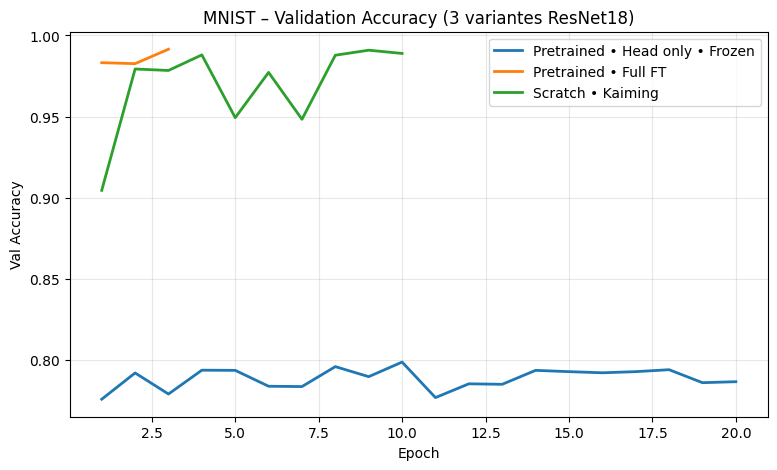

In [42]:
runs_root = Path("./runs")
run1 = runs_root / "headonly_pretrained_20_epochs_noSched_lr2E3_ADAMW_freezeBackbone"
run2 = runs_root / "headonly_pretrained_epochs3_noSched_lr2E3_ADAMW_NofreezeBackbone"
run3 = runs_root / "kaiming_NoPreTrained_epochs20_noSched_lr2E3_ADAMW_"

plot_metric_across_runs(
    run_dirs=[run1, run2, run3],
    labels=[
        "Pretrained • Head only • Frozen",
        "Pretrained • Full FT",
        "Scratch • Kaiming",
    ],
    metric="val_acc",                     # ou "val_loss", "train_acc", etc.
    title="MNIST – Validation Accuracy (3 variantes ResNet18)",
    smooth_window=1,                      # ex. 3 ou 5 pour lisser un peu
    save_path="./runs/fig_val_acc_3runs.png",
)

### Predictions des modeles

#### Fonctions d'affichage de 20 images du dataset + label attribué par le model

In [44]:
# --- CHARGEMENT DU DATASET ---
def get_mnist_loader(pretrained: bool, data_dir="./data"):
    tf = build_transform(pretrained)
    dataset = datasets.MNIST(data_dir, train=False, download=True, transform=tf)
    return dataset


# --- AFFICHAGE DE 20 IMAGES AVEC PREDICTIONS ---
def show_random_predictions(model, dataset, pretrained, n=20):
    indices = random.sample(range(len(dataset)), n)
    samples = [dataset[i] for i in indices]
    images, labels = zip(*samples)
    x = torch.stack(images).to(DEVICE)

    with torch.no_grad():
        logits = model(x)
        preds = logits.argmax(1).cpu()

    # on repasse en numpy pour affichage (re-normalisation simple)
    imgs = x.cpu()
    imgs = imgs.permute(0, 2, 3, 1).numpy()

    plt.figure(figsize=(12, 6))
    for i in range(n):
        plt.subplot(4, 5, i + 1)
        img = imgs[i]
        # remet dans [0,1] pour affichage sans dénormaliser complètement
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"T:{labels[i]} / P:{preds[i]}", fontsize=10)
    plt.suptitle("MNIST – Vrai label (T) / Prédiction (P)", fontsize=14)
    plt.tight_layout()
    plt.show()


#### Prediction model 

Modèle chargé depuis : ./runs/headonly_pretrained_epochs3_noSched_lr2E3_ADAMW_NofreezeBackbone/best.pt


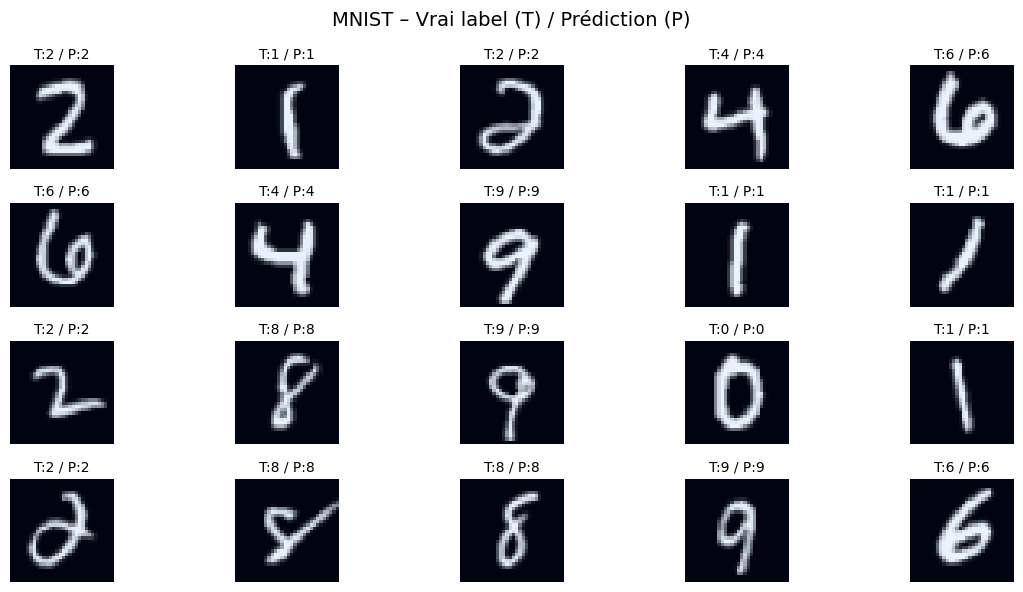

In [48]:
path_best_model = "./runs/headonly_pretrained_epochs3_noSched_lr2E3_ADAMW_NofreezeBackbone/best.pt"  # à adapter
model, pretrained = load_model(path_best_model)
dataset = get_mnist_loader(pretrained)

show_random_predictions(model, dataset, pretrained, n=20)

# Expérience 2